In [1]:
import matplotlib.pyplot as plt
import numpy as np
import IPython
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_io as tfio
import functools
from pedalboard import load_plugin
from ReverberatorEstimator import layers, loss
import warnings
warnings.filterwarnings('ignore')
import time
import os
import librosa.display
import datetime

2.6.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

3 Physical GPUs, 3 Logical GPUs


2021-12-18 19:46:43.852327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1917] Ignoring visible gpu device (device: 3, name: GeForce GT 710, pci bus id: 0000:02:00.0, compute capability: 3.5) with core count: 1. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2021-12-18 19:46:43.853564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 19:46:45.650905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6811 MB memory:  -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2021-12-18 19:46:45.652109: I tensorflow/core/common_runtime/gpu/gpu_d

In [3]:
sample_rate = 48000
num_params = 112
batch_size = 8

In [4]:
target_audio = tfio.audio.AudioIOTensor("Dataset/Wet/Snap_16ch.wav")
target_audio = target_audio.to_tensor()
target_audio = tf.slice(target_audio, begin=[0,0], size=[-1,1])
target_audio = tf.cast(target_audio, tf.float32) / 32768.0
target_audio = tf.squeeze(target_audio)
target_audio = tf.reshape(target_audio,(1, 96000))
input_audio = tfio.audio.AudioIOTensor("Dataset/Dry/New.wav")
input_audio = input_audio.to_tensor()
input_audio = tf.slice(input_audio, begin=[0,0], size=[-1,1])
input_audio = tf.cast(input_audio, tf.float32) / 32768.0
input_audio = tf.squeeze(input_audio)
input_audio = tf.reshape(input_audio,(1, 96000))

2021-12-18 19:46:45.815388: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [5]:
dataset_path = os.path.abspath("./Dataset")

dry_files = []

for f in range(batch_size):
    audio = tfio.audio.AudioIOTensor(dataset_path + "/Dry/New.wav")
    audio = audio.to_tensor()
    audio = tf.slice(audio, begin=[0,0], size=[-1,1])
    audio = tf.cast(audio, tf.float32) / 32768.0
    audio = tf.squeeze(audio)
    audio = tf.reshape(audio,(96000))
    dry_files.append(audio)
    
x_train = tf.stack(dry_files)

wet_files = []

for f in range(batch_size):
    audio = tfio.audio.AudioIOTensor(dataset_path + "/Wet/Snap_16ch.wav")
    audio = audio.to_tensor()
    audio = tf.slice(audio, begin=[0,0], size=[-1,1])
    audio = tf.cast(audio, tf.float32) / 32768.0
    audio = tf.squeeze(audio)
    audio = tf.reshape(audio,(96000))
    wet_files.append(audio)
    
y_train = tf.stack(wet_files)

In [6]:
logmelgram = layers.LogMelgramLayer(1024, 256, 128, sample_rate, 0.0, sample_rate//2, 1e-6)
audio_time = tfkl.Input(shape=(96000,), name="audio_time")

x = logmelgram(audio_time)
x = tfkl.BatchNormalization(name="input_norm")(x)
encoder_model = tfk.applications.MobileNetV2(input_shape=(x.shape[1], x.shape[2], x.shape[3]), alpha=1.0,
                                            include_top=True, weights=None, input_tensor=None, pooling=None,
                                            classes=np.sum(num_params).item(), classifier_activation="sigmoid")

hidden = encoder_model(x)

parameter_model = tfk.models.Model(audio_time, hidden, name="parameter_model")

parameters = parameter_model(audio_time)

vstlayer = layers.VSTProcessor("./Reverberator.vst3", sample_rate)
output = vstlayer([audio_time, parameters])

model = tfk.models.Model(audio_time, output, name="full_model")

spectral_loss = loss.multiScaleSpectralLoss(loss_type='L2', 
                                            mag_weight=1., 
                                            logmag_weight=1., 
                                            time_loss=True, 
                                            time_loss_type='L1', 
                                            time_loss_weight=1.0,
                                            delta_freq_weight=1.0,
                                            fft_sizes=(1024,512,256),
                                            overlap=0.0,
                                            batch_size=batch_size,
                                            sr=sample_rate,)
                                              
optimizer = tfk.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=spectral_loss, metrics=['mae'], run_eagerly=True)

No protocol specified
No protocol specified
No protocol specified
No protocol specified


In [7]:
parameter_model.summary()
model.summary()

Model: "parameter_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_time (InputLayer)      [(None, 96000)]           0         
_________________________________________________________________
log_melgram_layer (LogMelgra (None, 372, 128, 1)       0         
_________________________________________________________________
input_norm (BatchNormalizati (None, 372, 128, 1)       4         
_________________________________________________________________
mobilenetv2_1.00_372 (Functi (None, 112)               2400880   
Total params: 2,400,884
Trainable params: 2,366,770
Non-trainable params: 34,114
_________________________________________________________________
Model: "full_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio_time (Inpu

In [8]:
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True,
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                  factor=0.5,
                                  patience=10,
                                  cooldown=0,
                                  verbose=1,
                                  mode='auto',
                                  min_lr=0.0000016)

In [9]:
# Restore from latest checkpoint
try:
    model.load_weights(checkpoint_path)
except:
    print("No previous checkpoints found at %s" % checkpoint_path)

In [10]:
audio_pre = (model.call(input_audio)).numpy()[0]
old_params = parameter_model(input_audio).numpy()[0]
print(old_params)

2021-12-18 19:46:51.516159: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2021-12-18 19:46:51.815144: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[0.7006363  0.6241311  0.62432116 0.5589983  0.83464867 0.6346189
 0.5021172  0.71159405 0.45006773 0.83389413 0.5128484  0.73637646
 0.48666444 0.4297635  0.5658632  0.5475032  0.49123675 0.61885804
 0.33528322 0.43025053 0.5203907  0.7294591  0.5949034  0.55758864
 0.7326261  0.42615747 0.5559783  0.7000025  0.48744547 0.6620106
 0.6048161  0.44240028 0.1948925  0.42508382 0.7306338  0.5821155
 0.7002803  0.36049172 0.36122093 0.70846796 0.68844056 0.26710021
 0.28234875 0.28840262 0.7345565  0.70080143 0.6301386  0.4258524
 0.3868316  0.4521887  0.4571654  0.43340853 0.42825186 0.2714466
 0.71654856 0.7628566  0.55207163 0.23200004 0.5035204  0.8383157
 0.51018894 0.4908488  0.7270467  0.52346987 0.60004836 0.5631612
 0.29276112 0.49276045 0.17189968 0.84216493 0.75069755 0.16051747
 0.5489081  0.28679782 0.8103658  0.8009286  0.60660493 0.24076436
 0.43364656 0.8309177  0.6538276  0.709081   0.2709463  0.3771047
 0.6470814  0.5325962  0.38590026 0.2704775  0.3023688  0.788368
 0.71

In [11]:
start_time = time.time()
history = model.fit(x_train, y_train, verbose=1, epochs=1000,
         callbacks=[model_cp,reduce_lr])
print("Training took %d seconds" % (time.time() - start_time))

Epoch 1/1000


2021-12-18 19:46:52.110749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 29s 29s/step - loss: 10.7257 - mae: 0.0157

Epoch 00001: loss improved from inf to 10.72574, saving model to checkpoints/cp.ckpt
Epoch 2/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2626 - mae: 0.0126

Epoch 00002: loss improved from 10.72574 to 3.26256, saving model to checkpoints/cp.ckpt
Epoch 3/1000
1/1 [==============================] - 29s 29s/step - loss: 3.3214 - mae: 0.0119

Epoch 00003: loss did not improve from 3.26256
Epoch 4/1000
1/1 [==============================] - 29s 29s/step - loss: 3.3476 - mae: 0.0120

Epoch 00004: loss did not improve from 3.26256
Epoch 5/1000
1/1 [==============================] - 29s 29s/step - loss: 3.3476 - mae: 0.0120

Epoch 00005: loss did not improve from 3.26256
Epoch 6/1000
1/1 [==============================] - 29s 29s/step - loss: 3.3476 - mae: 0.0120

Epoch 00006: loss did not improve from 3.26256
Epoch 7/1000
1/1 [==============================] - 29s 29s/step - loss: 3.3761 

1/1 [==============================] - 29s 29s/step - loss: 3.2806 - mae: 0.0122

Epoch 00058: loss did not improve from 3.26256
Epoch 59/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2806 - mae: 0.0122

Epoch 00059: loss did not improve from 3.26256
Epoch 60/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2806 - mae: 0.0122

Epoch 00060: loss did not improve from 3.26256
Epoch 61/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2806 - mae: 0.0122

Epoch 00061: loss did not improve from 3.26256
Epoch 62/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2806 - mae: 0.0122

Epoch 00062: loss did not improve from 3.26256
Epoch 63/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2806 - mae: 0.0122

Epoch 00063: loss did not improve from 3.26256
Epoch 64/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2806 - mae: 0.0122

Epoch 00064: loss did not improve from 3.26256
Epoch 65/1000

1/1 [==============================] - 29s 29s/step - loss: 3.2594 - mae: 0.0120

Epoch 00114: loss did not improve from 3.25807
Epoch 115/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2594 - mae: 0.0120

Epoch 00115: loss did not improve from 3.25807
Epoch 116/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2594 - mae: 0.0120

Epoch 00116: loss did not improve from 3.25807
Epoch 117/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2594 - mae: 0.0120

Epoch 00117: loss did not improve from 3.25807
Epoch 118/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2594 - mae: 0.0120

Epoch 00118: loss did not improve from 3.25807
Epoch 119/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2594 - mae: 0.0120

Epoch 00119: loss did not improve from 3.25807
Epoch 120/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2594 - mae: 0.0120

Epoch 00120: loss did not improve from 3.25807
Epoch 1

1/1 [==============================] - 29s 29s/step - loss: 3.2491 - mae: 0.0124

Epoch 00169: loss did not improve from 3.24651
Epoch 170/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2491 - mae: 0.0124

Epoch 00170: loss did not improve from 3.24651
Epoch 171/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2491 - mae: 0.0124

Epoch 00171: loss did not improve from 3.24651
Epoch 172/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2491 - mae: 0.0124

Epoch 00172: loss did not improve from 3.24651
Epoch 173/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2491 - mae: 0.0124

Epoch 00173: loss did not improve from 3.24651
Epoch 174/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2491 - mae: 0.0124

Epoch 00174: loss did not improve from 3.24651
Epoch 175/1000
1/1 [==============================] - 29s 29s/step - loss: 3.2491 - mae: 0.0124

Epoch 00175: loss did not improve from 3.24651
Epoch 1

1/1 [==============================] - 30s 30s/step - loss: 3.2485 - mae: 0.0124

Epoch 00226: loss did not improve from 3.24640
Epoch 227/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2491 - mae: 0.0124

Epoch 00227: loss did not improve from 3.24640
Epoch 228/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2491 - mae: 0.0124

Epoch 00228: loss did not improve from 3.24640
Epoch 229/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2579 - mae: 0.0119

Epoch 00229: loss did not improve from 3.24640
Epoch 230/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2579 - mae: 0.0119

Epoch 00230: loss did not improve from 3.24640
Epoch 231/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2579 - mae: 0.0119

Epoch 00231: loss did not improve from 3.24640
Epoch 232/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2579 - mae: 0.0119

Epoch 00232: loss did not improve from 3.24640
Epoch 2

1/1 [==============================] - 30s 30s/step - loss: 3.2518 - mae: 0.0124

Epoch 00283: loss did not improve from 3.24625
Epoch 284/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2676 - mae: 0.0122

Epoch 00284: loss did not improve from 3.24625
Epoch 285/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2676 - mae: 0.0122

Epoch 00285: loss did not improve from 3.24625
Epoch 286/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2676 - mae: 0.0122

Epoch 00286: loss did not improve from 3.24625
Epoch 287/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2676 - mae: 0.0122

Epoch 00287: loss did not improve from 3.24625
Epoch 288/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2482 - mae: 0.0125

Epoch 00288: loss did not improve from 3.24625
Epoch 289/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2482 - mae: 0.0125

Epoch 00289: loss did not improve from 3.24625
Epoch 2

1/1 [==============================] - 30s 30s/step - loss: 3.2436 - mae: 0.0118

Epoch 00339: loss did not improve from 3.23223
Epoch 340/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2328 - mae: 0.0121

Epoch 00340: loss did not improve from 3.23223
Epoch 341/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2328 - mae: 0.0121

Epoch 00341: loss did not improve from 3.23223
Epoch 342/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2328 - mae: 0.0121

Epoch 00342: loss did not improve from 3.23223
Epoch 343/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2328 - mae: 0.0121

Epoch 00343: loss did not improve from 3.23223
Epoch 344/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2328 - mae: 0.0121

Epoch 00344: loss did not improve from 3.23223
Epoch 345/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2328 - mae: 0.0121

Epoch 00345: loss did not improve from 3.23223
Epoch 3

1/1 [==============================] - 30s 30s/step - loss: 3.2251 - mae: 0.0121

Epoch 00395: loss did not improve from 3.22513
Epoch 396/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2251 - mae: 0.0121

Epoch 00396: loss did not improve from 3.22513
Epoch 397/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2251 - mae: 0.0121

Epoch 00397: loss did not improve from 3.22513
Epoch 398/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2251 - mae: 0.0121

Epoch 00398: loss did not improve from 3.22513
Epoch 399/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2251 - mae: 0.0121

Epoch 00399: loss did not improve from 3.22513
Epoch 400/1000
1/1 [==============================] - 31s 31s/step - loss: 3.2251 - mae: 0.0121

Epoch 00400: loss did not improve from 3.22513
Epoch 401/1000
1/1 [==============================] - 31s 31s/step - loss: 3.2251 - mae: 0.0121

Epoch 00401: loss did not improve from 3.22513
Epoch 4

1/1 [==============================] - 30s 30s/step - loss: 3.2240 - mae: 0.0120

Epoch 00451: loss did not improve from 3.22258
Epoch 452/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2240 - mae: 0.0120

Epoch 00452: loss did not improve from 3.22258
Epoch 453/1000
1/1 [==============================] - 31s 31s/step - loss: 3.2240 - mae: 0.0120

Epoch 00453: loss did not improve from 3.22258
Epoch 454/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2226 - mae: 0.0121

Epoch 00454: loss did not improve from 3.22258
Epoch 455/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2226 - mae: 0.0121

Epoch 00455: loss did not improve from 3.22258
Epoch 456/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2226 - mae: 0.0121

Epoch 00456: loss did not improve from 3.22258
Epoch 457/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2226 - mae: 0.0121

Epoch 00457: loss did not improve from 3.22258
Epoch 4

1/1 [==============================] - 30s 30s/step - loss: 3.1928 - mae: 0.0119

Epoch 00507: loss did not improve from 3.19283
Epoch 508/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2030 - mae: 0.0120

Epoch 00508: loss did not improve from 3.19283
Epoch 509/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2030 - mae: 0.0120

Epoch 00509: loss did not improve from 3.19283
Epoch 510/1000
1/1 [==============================] - 30s 30s/step - loss: 3.2030 - mae: 0.0120

Epoch 00510: loss did not improve from 3.19283
Epoch 511/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1928 - mae: 0.0119

Epoch 00511: loss did not improve from 3.19283
Epoch 512/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1928 - mae: 0.0119

Epoch 00512: loss did not improve from 3.19283
Epoch 513/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1928 - mae: 0.0119

Epoch 00513: loss did not improve from 3.19283
Epoch 5

1/1 [==============================] - 30s 30s/step - loss: 3.1869 - mae: 0.0114

Epoch 00563: loss did not improve from 3.16046
Epoch 564/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1869 - mae: 0.0114

Epoch 00564: loss did not improve from 3.16046
Epoch 565/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1869 - mae: 0.0114

Epoch 00565: loss did not improve from 3.16046
Epoch 566/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1605 - mae: 0.0119

Epoch 00566: loss did not improve from 3.16046
Epoch 567/1000
1/1 [==============================] - 31s 31s/step - loss: 3.1605 - mae: 0.0119

Epoch 00567: loss did not improve from 3.16046
Epoch 568/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1605 - mae: 0.0119

Epoch 00568: loss did not improve from 3.16046
Epoch 569/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1605 - mae: 0.0119

Epoch 00569: loss did not improve from 3.16046
Epoch 5

1/1 [==============================] - 30s 30s/step - loss: 3.1681 - mae: 0.0113

Epoch 00619: loss did not improve from 3.14869
Epoch 620/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1681 - mae: 0.0113

Epoch 00620: loss did not improve from 3.14869
Epoch 621/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1681 - mae: 0.0113

Epoch 00621: loss did not improve from 3.14869
Epoch 622/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1693 - mae: 0.0113

Epoch 00622: loss did not improve from 3.14869
Epoch 623/1000
1/1 [==============================] - 31s 31s/step - loss: 3.1511 - mae: 0.0118

Epoch 00623: loss did not improve from 3.14869
Epoch 624/1000
1/1 [==============================] - 31s 31s/step - loss: 3.1511 - mae: 0.0118

Epoch 00624: loss did not improve from 3.14869
Epoch 625/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1511 - mae: 0.0118

Epoch 00625: loss did not improve from 3.14869
Epoch 6

1/1 [==============================] - 31s 31s/step - loss: 3.1534 - mae: 0.0116

Epoch 00676: loss did not improve from 3.14845
Epoch 677/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1534 - mae: 0.0116

Epoch 00677: loss did not improve from 3.14845
Epoch 678/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1659 - mae: 0.0111

Epoch 00678: loss did not improve from 3.14845
Epoch 679/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1659 - mae: 0.0111

Epoch 00679: loss did not improve from 3.14845
Epoch 680/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1659 - mae: 0.0111

Epoch 00680: loss did not improve from 3.14845
Epoch 681/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1653 - mae: 0.0113

Epoch 00681: loss did not improve from 3.14845
Epoch 682/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1653 - mae: 0.0113

Epoch 00682: loss did not improve from 3.14845
Epoch 6

1/1 [==============================] - 30s 30s/step - loss: 3.1361 - mae: 0.0116

Epoch 00732: loss did not improve from 3.13607
Epoch 733/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1361 - mae: 0.0116

Epoch 00733: loss did not improve from 3.13607
Epoch 734/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1361 - mae: 0.0116

Epoch 00734: loss did not improve from 3.13607
Epoch 735/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1361 - mae: 0.0116

Epoch 00735: loss did not improve from 3.13607
Epoch 736/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1361 - mae: 0.0116

Epoch 00736: loss did not improve from 3.13607
Epoch 737/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1361 - mae: 0.0116

Epoch 00737: loss did not improve from 3.13607
Epoch 738/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1281 - mae: 0.0116

Epoch 00738: loss improved from 3.13607 to 3.12808, sa

1/1 [==============================] - 30s 30s/step - loss: 3.1300 - mae: 0.0113

Epoch 00788: loss did not improve from 3.12275
Epoch 789/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1317 - mae: 0.0113

Epoch 00789: loss did not improve from 3.12275
Epoch 790/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1317 - mae: 0.0113

Epoch 00790: loss did not improve from 3.12275
Epoch 791/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1317 - mae: 0.0113

Epoch 00791: loss did not improve from 3.12275
Epoch 792/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1317 - mae: 0.0113

Epoch 00792: loss did not improve from 3.12275
Epoch 793/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1354 - mae: 0.0114

Epoch 00793: loss did not improve from 3.12275
Epoch 794/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1354 - mae: 0.0114

Epoch 00794: loss did not improve from 3.12275
Epoch 7

1/1 [==============================] - 31s 31s/step - loss: 3.1359 - mae: 0.0113

Epoch 00845: loss did not improve from 3.12275
Epoch 846/1000
1/1 [==============================] - 31s 31s/step - loss: 3.1359 - mae: 0.0113

Epoch 00846: loss did not improve from 3.12275
Epoch 847/1000
1/1 [==============================] - 31s 31s/step - loss: 3.1359 - mae: 0.0113

Epoch 00847: loss did not improve from 3.12275
Epoch 848/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1579 - mae: 0.0111

Epoch 00848: loss did not improve from 3.12275
Epoch 849/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1579 - mae: 0.0111

Epoch 00849: loss did not improve from 3.12275
Epoch 850/1000
1/1 [==============================] - 31s 31s/step - loss: 3.1579 - mae: 0.0111

Epoch 00850: loss did not improve from 3.12275
Epoch 851/1000
1/1 [==============================] - 31s 31s/step - loss: 3.1579 - mae: 0.0111

Epoch 00851: loss did not improve from 3.12275
Epoch 8

1/1 [==============================] - 30s 30s/step - loss: 3.1369 - mae: 0.0114

Epoch 00902: loss did not improve from 3.12275
Epoch 903/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1369 - mae: 0.0114

Epoch 00903: loss did not improve from 3.12275
Epoch 904/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1369 - mae: 0.0114

Epoch 00904: loss did not improve from 3.12275
Epoch 905/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1369 - mae: 0.0114

Epoch 00905: loss did not improve from 3.12275
Epoch 906/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1369 - mae: 0.0114

Epoch 00906: loss did not improve from 3.12275
Epoch 907/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1369 - mae: 0.0114

Epoch 00907: loss did not improve from 3.12275
Epoch 908/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1369 - mae: 0.0114

Epoch 00908: loss did not improve from 3.12275
Epoch 9

1/1 [==============================] - 31s 31s/step - loss: 3.1385 - mae: 0.0109

Epoch 00959: loss did not improve from 3.12275
Epoch 960/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1385 - mae: 0.0109

Epoch 00960: loss did not improve from 3.12275
Epoch 961/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1385 - mae: 0.0109

Epoch 00961: loss did not improve from 3.12275
Epoch 962/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1385 - mae: 0.0109

Epoch 00962: loss did not improve from 3.12275
Epoch 963/1000
1/1 [==============================] - 31s 31s/step - loss: 3.1385 - mae: 0.0109

Epoch 00963: loss did not improve from 3.12275
Epoch 964/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1385 - mae: 0.0109

Epoch 00964: loss did not improve from 3.12275
Epoch 965/1000
1/1 [==============================] - 30s 30s/step - loss: 3.1385 - mae: 0.0109

Epoch 00965: loss did not improve from 3.12275
Epoch 9

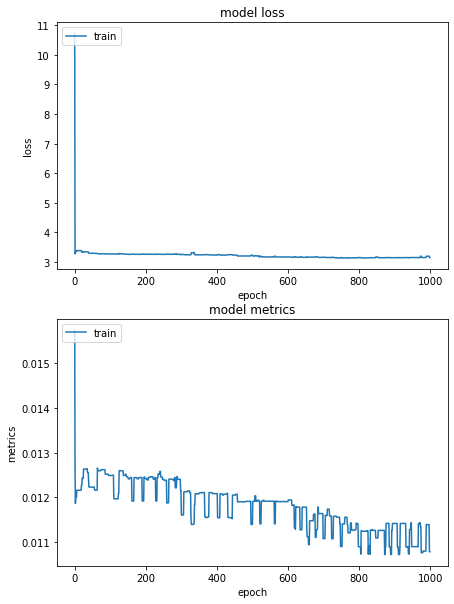

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
ax[0].plot(history.history['loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[1].plot(history.history['mae'])
ax[1].set_title('model metrics')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

In [13]:
output_audio = model(input_audio)

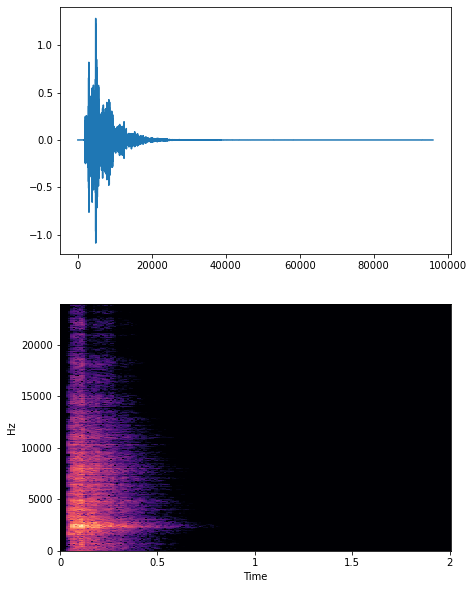

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
ax[0].plot(audio_pre)
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_pre)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1])

Text(0.5, 1.0, 'Spectrogram of target audio')

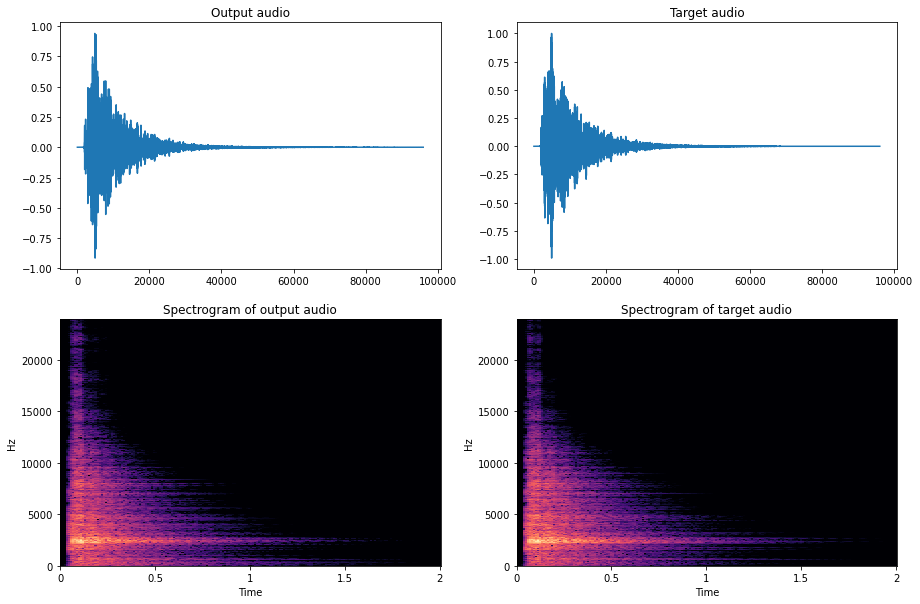

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax[0,0].plot(output_audio.numpy()[0])
ax[0,0].set_title("Output audio")
D = librosa.amplitude_to_db(np.abs(librosa.stft(output_audio.numpy()[0])), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1,0])
ax[1,0].set_title("Spectrogram of output audio")
ax[0,1].plot(target_audio.numpy()[0])
ax[0,1].set_title("Target audio")
D = librosa.amplitude_to_db(np.abs(librosa.stft(target_audio.numpy()[0])), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sample_rate, ax=ax[1,1])
ax[1,1].set_title("Spectrogram of target audio")

In [16]:
IPython.display.Audio(output_audio, rate=sample_rate, autoplay=True)

In [17]:
IPython.display.Audio(audio_pre, rate=sample_rate)

In [18]:
IPython.display.Audio(target_audio, rate=sample_rate)

In [19]:
# Dump values to .csv files
np.savetxt("output_audio.csv", output_audio.numpy()[0], delimiter=",")
np.savetxt("target_audio.csv", target_audio.numpy()[0], delimiter=",")

In [20]:
from scipy.io.wavfile import write
write("output_audio.wav", sample_rate, output_audio.numpy()[0])
write("target_audio.wav", sample_rate, target_audio.numpy()[0])

In [21]:
parameters = parameter_model(input_audio)

In [22]:
params = parameters.numpy()[0]
filter_c = 1
for i in range(num_params):
    if i < 16:
        print("b_%i = %f" % (i, params[i]))
    elif i < 32:
        print("c_%i = %f" % (i-4, params[i]))
    else:
        j = (i-32) % 5
        
        if j is 0:
            print("\nFilter %i:" % filter_c)
            filter_c = filter_c + 1
            print("c_hp = %f" % params[i])
        elif j is 1:
            print("c_bp = %f" % params[i])
        elif j is 2:
            print("c_lp = %f" % params[i])
        elif j is 3:
            print("g = %f" % params[i])
        elif j is 4:
            print("R = %f" % params[i])

b_0 = 0.742343
b_1 = 0.669943
b_2 = 0.622092
b_3 = 0.558114
b_4 = 0.868028
b_5 = 0.667743
b_6 = 0.495815
b_7 = 0.743745
b_8 = 0.449040
b_9 = 0.869502
b_10 = 0.531295
b_11 = 0.769838
b_12 = 0.545789
b_13 = 0.410901
b_14 = 0.585402
b_15 = 0.549716
c_12 = 0.490630
c_13 = 0.668337
c_14 = 0.320153
c_15 = 0.423116
c_16 = 0.518407
c_17 = 0.734121
c_18 = 0.578077
c_19 = 0.590711
c_20 = 0.773232
c_21 = 0.385975
c_22 = 0.568373
c_23 = 0.669446
c_24 = 0.564542
c_25 = 0.692718
c_26 = 0.624355
c_27 = 0.432730

Filter 1:
c_hp = 0.155358
c_bp = 0.405763
c_lp = 0.756975
g = 0.575962
R = 0.736505

Filter 2:
c_hp = 0.378437
c_bp = 0.358068
c_lp = 0.738154
g = 0.716051
R = 0.241339

Filter 3:
c_hp = 0.247676
c_bp = 0.262082
c_lp = 0.769337
g = 0.727260
R = 0.664371

Filter 4:
c_hp = 0.392938
c_bp = 0.371260
c_lp = 0.446164
g = 0.446014
R = 0.424836

Filter 5:
c_hp = 0.392925
c_bp = 0.245113
c_lp = 0.742257
g = 0.788148
R = 0.579661

Filter 6:
c_hp = 0.172964
c_bp = 0.497897
c_lp = 0.876516
g = 0.502527
R

(-1.0, 1.0)

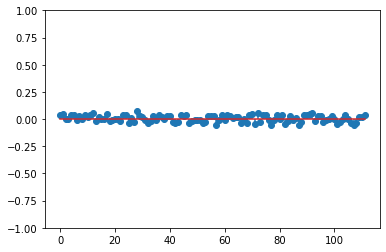

In [23]:
param_diff = params - old_params
plt.stem(param_diff)
plt.ylim([-1, 1])

In [24]:
# 500 + 500 + 1000 + 500